# Model predictive control: the tank problem
[Model predictive control](https://en.wikipedia.org/wiki/Model_predictive_control) uses a mathematical model to predict the future behaviour of a given system so as to calculate the best next course of action. For our concrete problem at hand, this is calculated by solving the following optimization problem:
\begin{equation}
\begin{array}{ll}
\underset{\{x_k, u_k, \forall k\}}{\text{minimize}} & \sum \limits_{k=1}^{N} (x_k - x_{ref})^2 \\
\text{subject to} & x_{k+1} = x_k + u_k, \hspace{0.3cm} \forall k=0,...,N-1 \\
& x_k \in [0,7], \hspace{0.3cm} \forall k=1,...,N+1 \\
& u_k \in [0,1], \hspace{0.3cm} \forall k=0,...,N
\end{array}
\end{equation}
where $x_k$ is the predicted state of the system $x$ at time step $k$, while $u_k$ is the calculated input for time $k$ and with $x_{ref} = 5$, $N = 20$ and one time step per minute. 

> The states $x_k$ are all defined by the dynamics of the system. However, technically we have to include them as the optimization variables unless we want to substitute all the equality constraints.

## Initialization and variable definition

In [1]:
# Initialization
import xpress as xp
#%env XPRESS=..
import matplotlib.pyplot as plt

model = xp.problem("The tank problem")

# Parameter definition
Nu = 20
xref = 5
x0 = 0
Nx = 21

# Variable definition
u = {k : xp.var(vartype = xp.continuous, lb = 0, ub = 1, name =f'Inflow at {k}')
    for k in range(Nu)}
x = {k : xp.var(vartype = xp.continuous, lb = 0, ub = 7, name = f'Volume at {k}')
    for k in range(Nx)}
model.addVariable(u,x)

## The dynamics
At this point, we introduce the dynamics of the system. Note that we already included the lower and upper bounds in the variable definition, so the only thing left from the optimization problem is the dyanmics.

In [2]:
dynamics = (xp.constraint(x[k+1] == x[k] + u[k], 
                          name = f'Dynamics from {k} to {k+1}')
           for k in range(Nu))

## Cost function
Now we add the nonlinear cost function.

In [3]:
model.setObjective(xp.Sum((x[k] - xref)**2 for k in range(Nx)))

## The initial condition
Finally, we set the initial condition for the problem. Interestingly enough, this is the only part of the problem that will change from one iteration to another.

In [4]:
initial_condition = xp.constraint(x[0] == x0, name = 'Initial condition')
model.addConstraint(dynamics, initial_condition)

## Solution and post-processing

In [5]:
model.solve();

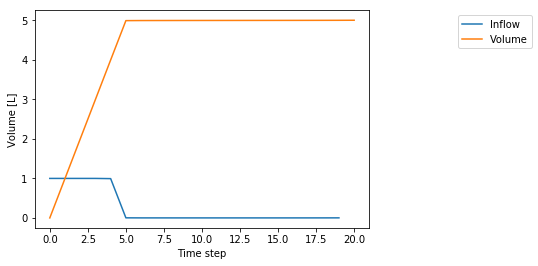

In [6]:
uVal = [model.getSolution(u[k]) for k in range(Nu)]
xVal = [model.getSolution(x[k]) for k in range(Nx)]
plt.plot(range(Nu), uVal, label='Inflow')
plt.plot(range(Nx), xVal, label='Volume')
plt.legend(bbox_to_anchor=(1.5, 1));
plt.xlabel("Time step")
plt.ylabel("Volume [L]");